# Setup

In [1]:
from idrtools import math
from twins_embedding import TwinsEmbeddingAnalysis
from matplotlib import pyplot as plt
from matplotlib import colors
from tqdm.notebook import tqdm
from astropy.table import Table
import utils
import numpy as np

/home/kyle/supernova/snfactory/manifold_twins/analysis/twins_embedding.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

In [3]:
a = TwinsEmbeddingAnalysis()
a.settings['figure_directory'] = './output_generation/figures/'
a.settings['latex_directory'] = './output_generation/latex/'
a.run_analysis()

Loading dataset...
    IDR:          BLACKSTON
    Phase range: [-5.0, 5.0] days
    Bin velocity: 1000.0



Estimating the spectra at maximum light...
    Loaded cached stan model
    Using saved stan result
Reading between the lines...
    Loaded cached stan model
    Using saved stan result
Building masks...
    Masking 30/203 targets whose uncertainty power is 
    more than 0.100 of the intrinsic power.
Generating the manifold learning embedding...
Loading other indicators of diversity...
Fitting RBTL Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Reading between the lines plots

## Show spectra before and after

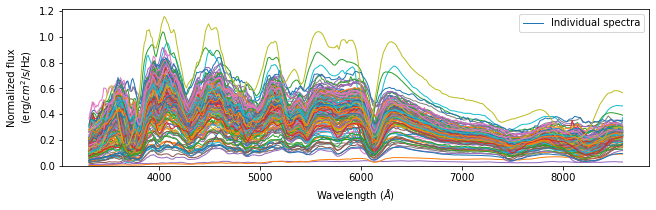

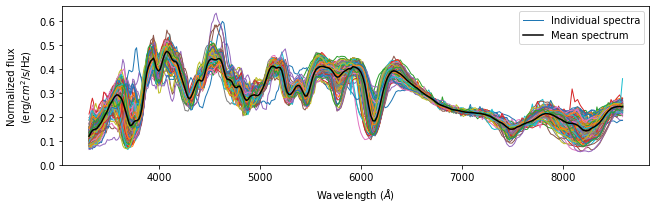

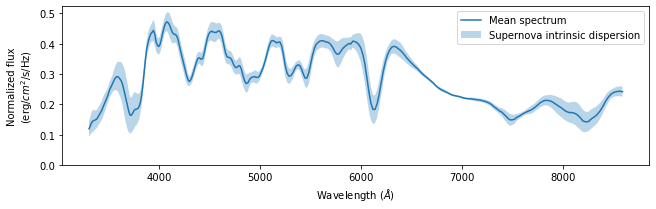

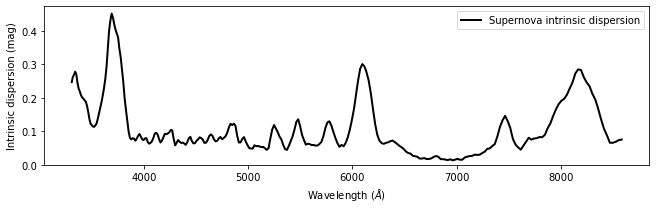

In [4]:
fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.maximum_flux[a.uncertainty_mask], lw=1, label='Individual spectra')
ax.legend()
a.savefig('spectra_at_maximum.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.scale_flux[a.uncertainty_mask], lw=1., label='Individual spectra')
a.plot_flux(ax, a.mean_flux, c='k', label='Mean spectrum')
ax.legend()
a.savefig('scale_spectra.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.mean_flux, a.mean_flux * a.rbtl_result['fractional_dispersion'], label='Mean spectrum', uncertainty_label='Supernova intrinsic dispersion')
ax.legend()
a.savefig('scale_spectra_model.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
intrinsic_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])
ax.plot(a.wave, intrinsic_dispersion, c='k', lw=2, label='Supernova intrinsic dispersion')
ax.legend()
ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax.set_ylabel('Intrinsic dispersion (mag)')
ax.set_ylim(0, None)
a.savefig('rbtl_intrinsic_dispersion.pdf', fig)

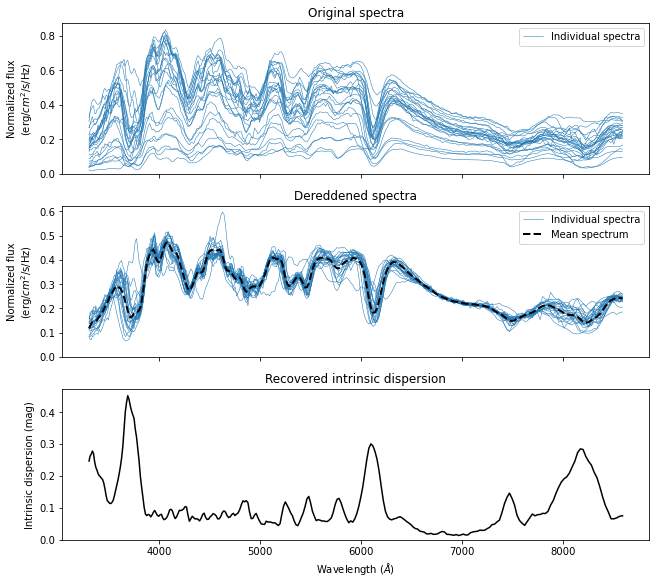

In [5]:
# Combined version

figsize = a.settings['spectrum_plot_figsize_triple']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, sharex=True)

a.plot_flux(ax1, a.maximum_flux[::8], lw=0.5, label='Individual spectra', c='C0')
ax1.set_title('Original spectra')
ax1.set_xlabel(None)

a.plot_flux(ax2, a.scale_flux[a.uncertainty_mask][::8], lw=0.5, label='Individual spectra', c='C0')
a.plot_flux(ax2, a.mean_flux, c='k', lw=2, ls='--', label='Mean spectrum')
ax2.set_title('Dereddened spectra')
ax2.set_xlabel(None)

intrinsic_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])
ax3.plot(a.wave, intrinsic_dispersion, c='k')
ax3.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax3.set_ylabel('Intrinsic dispersion (mag)')
ax3.set_title('Recovered intrinsic dispersion')
ax3.set_ylim(0, None)

a.savefig('rbtl_spectra_combined.pdf')

# Manifold learning plots

## Plot the parameter space

Text(0.5, 0, '$\\xi_1$')

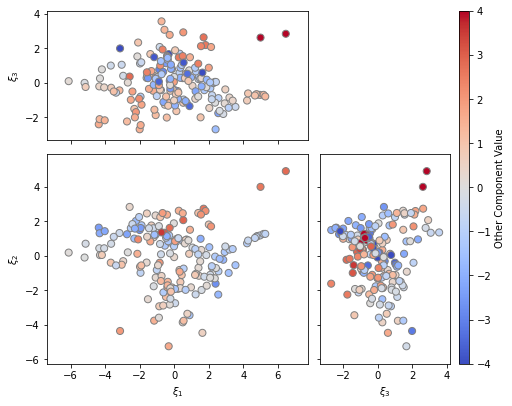

In [6]:
a.scatter_combined([a.embedding[:, 2], a.embedding[:, 1], a.embedding[:, 0]], a.uncertainty_mask, vmin=-4, vmax=4, label='Other Component Value')
a.savefig('embedding_components.pdf')
plt.gca().set_xlabel('$\\xi_1$')

## Slices through components

In [7]:
def plot_steps(ax, component, mask=True, num_steps=20, colorbar_aspect=50):
    mask = mask & a.uncertainty_mask

    use_embedding = a.embedding[mask, component]
    use_flux = a.scale_flux[mask]

    bin_edges = np.percentile(use_embedding, np.linspace(0, 100, num_steps + 1))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.

    sm = plt.cm.ScalarMappable(cmap=a.settings['colormap'], norm=plt.Normalize(vmin=bin_centers[0], vmax=bin_centers[-1]))
    sm._A = []

    for step in range(num_steps):
        step_mask = (use_embedding >= bin_edges[step]) & (use_embedding < bin_edges[step+1])
        step_embedding = use_embedding[step_mask]

        mean_val = np.mean(step_embedding)
        step_flux = np.median(use_flux[step_mask], axis=0)

        # Make the extreme values of components get plotted on top if everything overlaps.
        zorder = np.abs(mean_val)

        a.plot_flux(ax, step_flux, c=sm.to_rgba(mean_val), zorder=zorder)

    fig.colorbar(sm, ax=ax, orientation='vertical', label='Component Value', pad=0, aspect=colorbar_aspect)

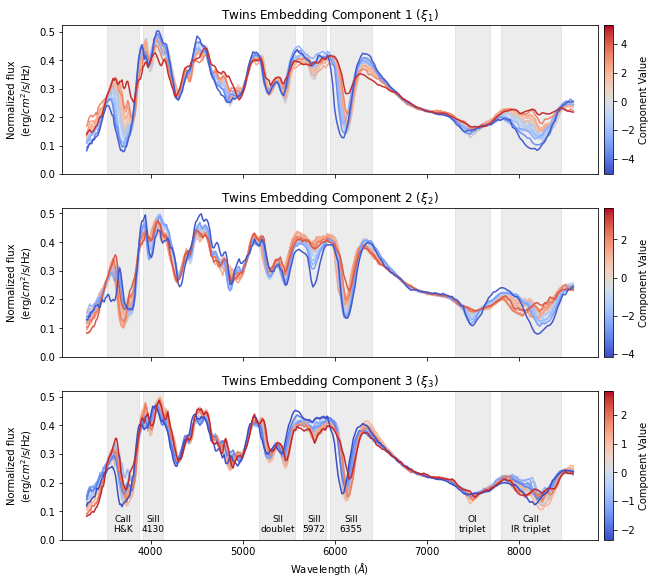

In [8]:
# All plots combined
# fig, axes = plt.subplots(3, 1, figsize=(a.settings['spectrum_plot_figsize'][0], a.settings['spectrum_plot_figsize'][1] * 3 - 1.5), sharex=True)
fig, axes = plt.subplots(3, 1, figsize=a.settings['spectrum_plot_figsize_triple'], sharex=True)

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

for component, ax in enumerate(axes):
    plot_steps(ax, component, colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)
        
    for line_label, (min_wave, max_wave) in label_lines.items():
        ax.axvspan(min_wave, max_wave, alpha=0.15, color='gray')
        mean_wave = (min_wave + max_wave) / 2.
        if component == 2:
            ax.text(mean_wave, 0.02, line_label, horizontalalignment='center', verticalalignment='bottom', fontsize=9.)

    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    # ax.set_ylabel('Normalized flux\n(erg/cm$^2$/s/Hz)')

a.savefig('component_steps_combined.pdf')

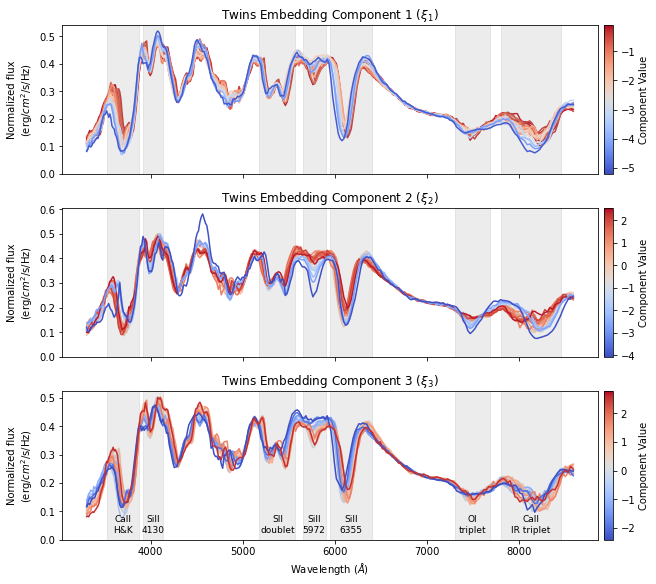

In [9]:
# All plots combined with a cut imposed for testing purposes.
# fig, axes = plt.subplots(3, 1, figsize=(a.settings['spectrum_plot_figsize'][0], a.settings['spectrum_plot_figsize'][1] * 3 - 1.5), sharex=True)
fig, axes = plt.subplots(3, 1, figsize=a.settings['spectrum_plot_figsize_triple'], sharex=True)

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

for component, ax in enumerate(axes):
    plot_steps(ax, component, (a.embedding[:, 0] < 0), colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)
        
    for line_label, (min_wave, max_wave) in label_lines.items():
        ax.axvspan(min_wave, max_wave, alpha=0.15, color='gray')
        mean_wave = (min_wave + max_wave) / 2.
        if component == 2:
            ax.text(mean_wave, 0.02, line_label, horizontalalignment='center', verticalalignment='bottom', fontsize=9.)

    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    # ax.set_ylabel('Normalized flux\n(erg/cm$^2$/s/Hz)')

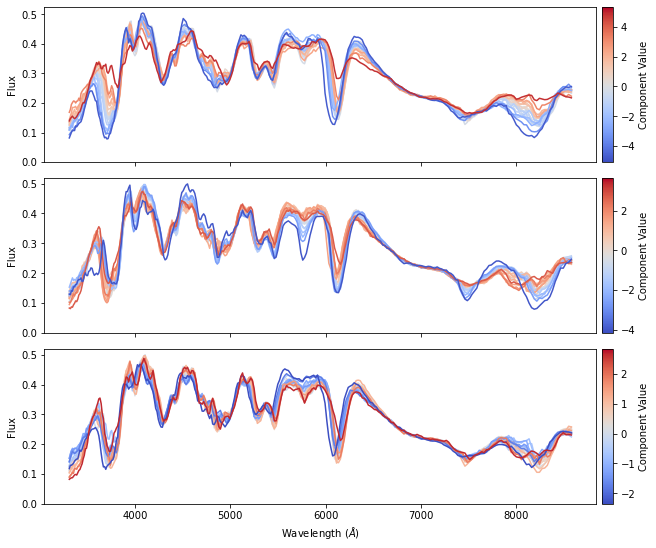

In [10]:
# Version for talks
fig, axes = plt.subplots(3, 1, figsize=(9, 7.5), sharex=True)

for component, ax in enumerate(axes):
    plot_steps(ax, component, colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)

    ax.set_ylabel('Flux')

a.savefig('component_steps_combined_talks.pdf')

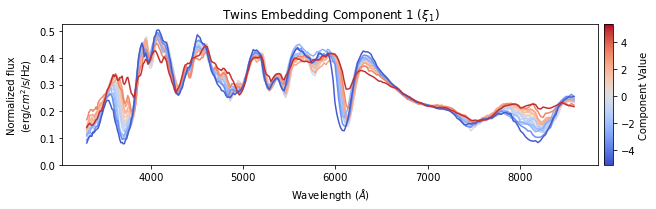

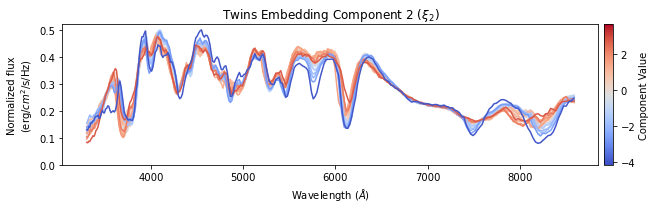

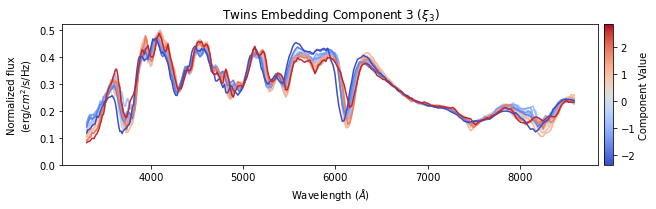

In [11]:
# Single plots
for component in range(a.settings['isomap_num_components']):
    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    plot_steps(ax, component)

## Reconstruction uncertainty

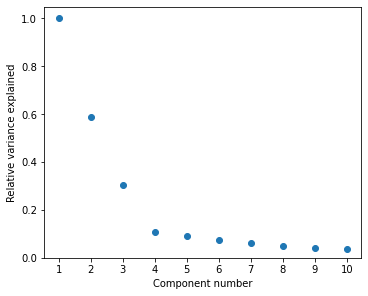

In [12]:
# Note: the total variance isn't defined for Isomap. The variances of the transfomed components
# do map onto the variance of real components though.
# In a separate notebook, we use GPs to reconstruct the spectra from the Isomap latent space
# which gives an absolute measure of the explained variance.

num_show = 10

# Do an initial embedding with as many components as possible to get the full variance.
embedding = a.generate_embedding(num_components=50)
variances = np.var(embedding[a.uncertainty_mask], axis=0)

ref_var = np.sum(variances[:10])

plot_ref = variances[0]

plt.figure()
plt.scatter(np.arange(num_show), variances[:num_show] / plot_ref, label='Contributed variance of each component')
plt.ylim(0, None)
plt.xlabel('Component number')
plt.ylabel('Relative variance explained')
plt.xticks(np.arange(num_show), np.arange(num_show) + 1)

a.savefig('isomap_component_variance.pdf')

## Twin reconstruction

In [59]:
from IPython.display import display
from scipy.spatial.distance import pdist
from scipy.stats import percentileofscore
import pandas as pd

def plot_twin_distances(embedding, twins_percentile=10, figsize=None):
    """Plot a histogram of where twins show up in the transformed
    embedding.
    """

    mask = a.uncertainty_mask

    spec_dists = pdist(a.fractional_differences[mask])
    embedding_dists = pdist(embedding[mask])

    splits = {
        "Best 10% of twinness": (0, 10),
        "10-20%": (10, 20),
        "20-50%": (20, 50),
        "Worst 50% of twinness": (50, 100),
    }

    # Set weight so that the histogram is 1 if we have every element in
    # that bin.
    weight = 100 / len(embedding_dists)

    all_percentiles = []
    all_weights = []

    all_spec_cuts = []
    all_embedding_cuts = []

    for label, (min_percentile, max_percentile) in splits.items():
        spec_cut = (spec_dists >= np.percentile(spec_dists, min_percentile)) & (
            spec_dists < np.percentile(spec_dists, max_percentile)
        )
        embedding_cut = (embedding_dists >= np.percentile(embedding_dists, min_percentile)) & (
            embedding_dists < np.percentile(embedding_dists, max_percentile)
        )
        percentiles = []
        for dist in embedding_dists[spec_cut]:
            percentiles.append(percentileofscore(embedding_dists, dist))
        percentiles = np.array(percentiles)
        weights = np.ones(len(percentiles)) * weight

        all_percentiles.append(percentiles)
        all_weights.append(weights)
        all_spec_cuts.append(spec_cut)
        all_embedding_cuts.append(embedding_cut)

    plt.figure(figsize=figsize)
    plt.hist(
        all_percentiles,
        100,
        (0, 100),
        weights=all_weights,
        histtype="barstacked",
        label=list(splits.keys()),
    )
    plt.xlabel("Recovered twinness percentile in the embedded space")
    plt.ylabel("Fraction in bin")
    plt.legend()

    plt.xlim(0, 100)
    plt.ylim(0, 1)

    for label, (min_percentile, max_percentile) in splits.items():
        plt.axvline(max_percentile, c="k", lw=2, ls="--")

    # Build leakage matrix.
    leakage_matrix = np.zeros((len(splits), len(splits)))
    for idx_1, label_1 in enumerate(splits.keys()):
        for idx_2, label_2 in enumerate(splits.keys()):
            spec_cut = all_spec_cuts[idx_1]
            embedding_cut = all_embedding_cuts[idx_2]
            leakage = np.sum(embedding_cut & spec_cut) / np.sum(spec_cut)
            leakage_matrix[idx_1, idx_2] = leakage

    # Print the leakage matrix using pandas
    df = pd.DataFrame(
        leakage_matrix,
        index=["From %s" % i for i in splits.keys()],
        columns=["To %s" % i for i in splits.keys()],
    )
    display(df)

    return leakage_matrix

,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.280914,0.276882,0.437500,0.004704
From 10-20%,0.173387,0.181452,0.547715,0.097446
From 20-50%,0.114945,0.109119,0.410710,0.365225
From Worst 50% of twinness,0.040199,0.042888,0.156494,0.760419


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.579973,0.313172,0.106855,0.000000
From 10-20%,0.190860,0.305780,0.502688,0.000672
From 20-50%,0.057585,0.105086,0.600045,0.237284
From Worst 50% of twinness,0.011293,0.013176,0.118042,0.857489


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.736559,0.235887,0.027554,0.000000
From 10-20%,0.196909,0.435484,0.367608,0.000000
From 20-50%,0.020614,0.105086,0.712973,0.161326
From Worst 50% of twinness,0.000941,0.002689,0.093170,0.903200


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.747984,0.222446,0.029570,0.000000
From 10-20%,0.188844,0.459677,0.351478,0.000000
From 20-50%,0.019942,0.103294,0.716782,0.159982
From Worst 50% of twinness,0.000672,0.001613,0.093708,0.904006


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.760753,0.208333,0.030914,0.000000
From 10-20%,0.190188,0.461694,0.348118,0.000000
From 20-50%,0.015460,0.107327,0.722384,0.154829
From Worst 50% of twinness,0.000538,0.001613,0.090750,0.906964


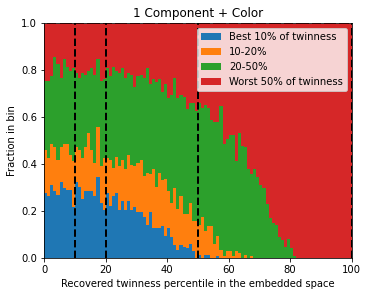

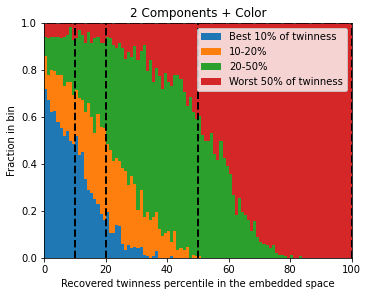

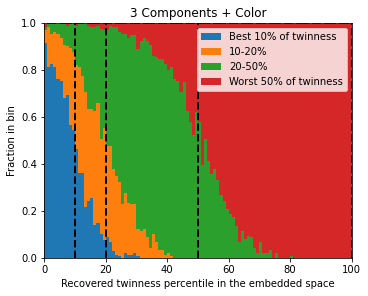

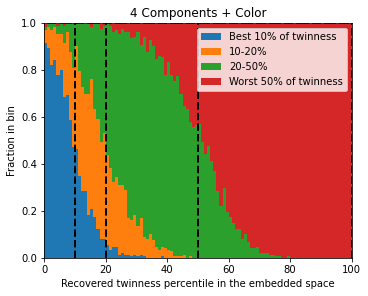

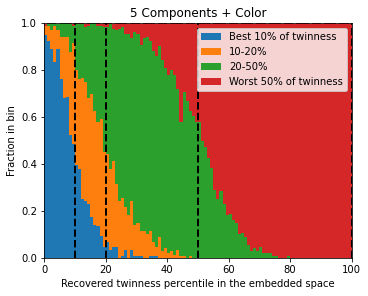

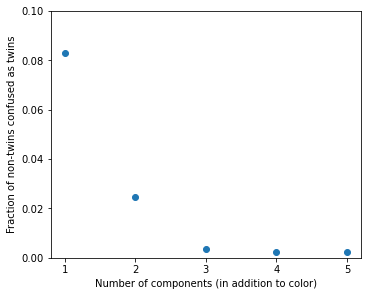

In [60]:
# Plot where twins and non-twins end up for different number of components.
# We also make a summary plot.
confused_fraction = []

plot_components = np.arange(1, 6)
for num_components in plot_components:
    embedding = a.generate_embedding(num_components=num_components)
    leakage_matrix = plot_twin_distances(embedding)
    if num_components == 1:
        title = '1 Component + Color'
    else:
        title = '%d Components + Color' % num_components
    plt.title(title)
    plt.xlabel('Recovered twinness percentile in the embedded space')
    a.savefig('twins_recovery_%d_components.pdf' % num_components)

    confused_fraction.append(leakage_matrix[3, 0] + leakage_matrix[3, 1])

plt.figure()
plt.scatter(np.arange(len(confused_fraction)) + 1, confused_fraction)
plt.xticks(plot_components, plot_components)
plt.ylim(0, 0.1)
plt.xlabel('Number of components (in addition to color)')
plt.ylabel('Fraction of non-twins confused as twins')
a.savefig('twins_confusion.pdf')

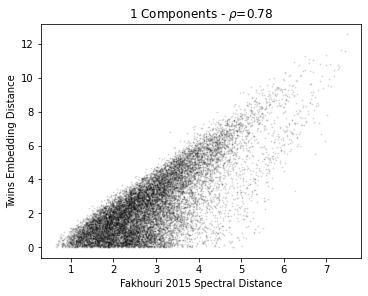

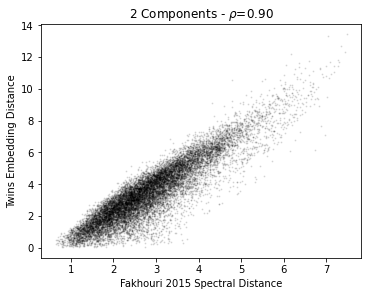

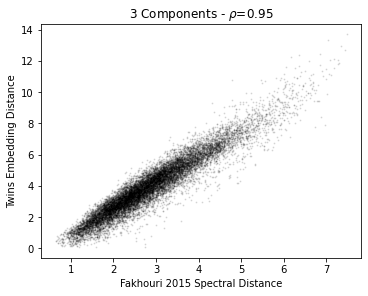

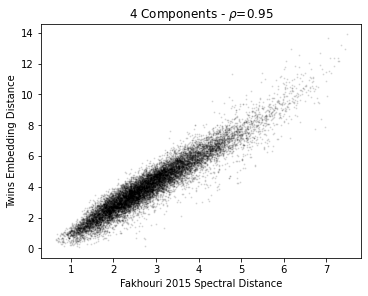

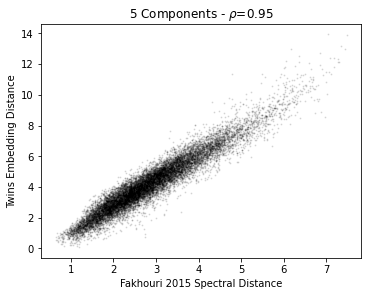

In [99]:
def plot_twin_distances(embedding):
    """Scatter the spectral distances vs the embedding distances."""

    mask = a.uncertainty_mask

    spec_dists = pdist(a.fractional_differences[mask])
    embedding_dists = pdist(embedding[mask])

    plt.figure()
    plt.scatter(spec_dists, embedding_dists, s=1, c='k', alpha=0.1)
    math.plot_binned_function
    plt.title(f'{embedding.shape[1]} Components - $\\rho$={np.corrcoef([spec_dists, embedding_dists])[0, 1]:.2f}')
    plt.xlabel('Fakhouri 2015 Spectral Distance')
    plt.ylabel('Twins Embedding Distance')
    
for i in range(1, 6):
    e = a.generate_embedding(num_components=i)
    plot_twin_distances(e)

## Comparision to Branch classifications

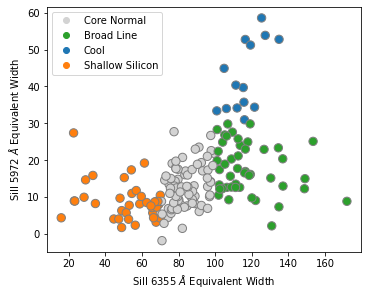

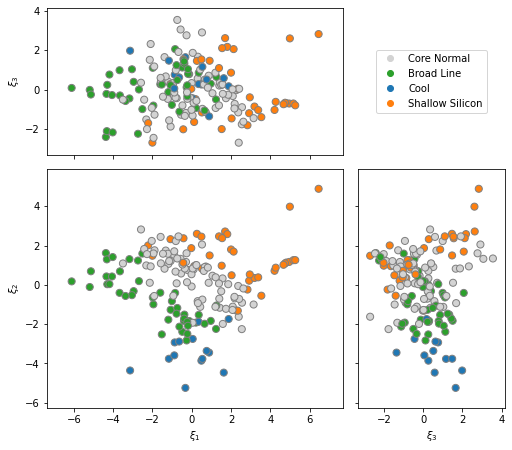

In [15]:
branch_colors = {
    # 'Broad Line': 'b',
    # 'Cool': 'r',
    # 'Core Normal': 'black',
    # 'Shallow Silicon': 'green',
    
    # 'Broad Line': 'C2',
    # 'Cool': 'C0',
    # 'Shallow Silicon': 'C3',
    # 'Core Normal': 'black',
    
    'Core Normal': 'lightgray',
    'Broad Line': 'C2',
    'Cool': 'C0',
    'Shallow Silicon': 'C1',
}

branch_classification = a.indicators['branch_classification']
mask = ~branch_classification.mask

from matplotlib.colors import ListedColormap
cmap = ListedColormap(branch_colors.values())
color_id_map = {j:i for i, j in enumerate(branch_colors)}
colors = np.array([color_id_map[i] for i in branch_classification[mask]])

fig, ax = plt.subplots()
scatter = ax.scatter(
    a.indicators['spectrum_EWSiII6355'][mask],
    a.indicators['spectrum_EWSiII5972'][mask],
    c=colors,
    cmap=cmap,
    s=a.settings['scatter_plot_marker_size'],
    edgecolors='gray'
)
ax.set_xlabel('SiII 6355 $\AA$ Equivalent Width')
ax.set_ylabel('SiII 5972 $\AA$ Equivalent Width')

ax.legend(handles=scatter.legend_elements()[0], labels=branch_colors.keys())

a.savefig('branch_classification.pdf', fig)

a.scatter_combined(branch_classification, mask, discrete_color_map=branch_colors, s=50, edgecolors='gray')
a.savefig('branch_labels.pdf')

## Variation of Core Normal SNe Ia

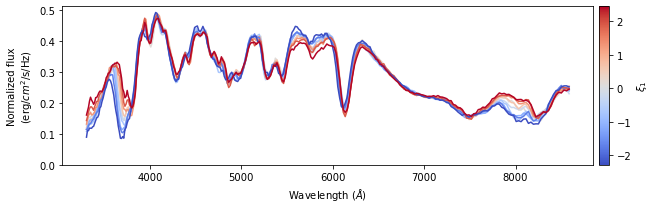

In [16]:
core_normal_cut = a.indicators['branch_classification'] == 'Core Normal'

component = 0

cut_flux = a.scale_flux[core_normal_cut]
cut_coord = a.embedding[core_normal_cut][:, component]

sort_flux = cut_flux[np.argsort(cut_coord)]
sort_coord = cut_coord[np.argsort(cut_coord)]

num_bins = 10

cmap = a.settings['colormap']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.percentile(cut_coord, 100 / num_bins / 2), vmax=np.percentile(cut_coord, 100 * (1 - 1. / num_bins / 2))))
sm._A = []

def plot_spec(bin_idx, ax):
    min_idx = int(len(sort_coord) / num_bins * bin_idx)
    max_idx = int(len(sort_coord) / num_bins * (bin_idx + 1))
    bin_flux = sort_flux[min_idx:max_idx]
    
    f = np.median(bin_flux, axis=0)
    
    mean_val = np.mean(sort_coord[min_idx:max_idx])
    
    a.plot_flux(ax, f, c=sm.to_rgba(mean_val), zorder=np.abs(mean_val))
    # plt.plot(a.wave, f * spectrum_plot_scale, c=sm.to_rgba(mean_val), zorder=np.abs(mean_val))
    
fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
for i in range(num_bins):
    plot_spec(i, ax)

fig.colorbar(sm, ax=ax, orientation='vertical', label='$\\xi_%d$' % (component + 1), pad=0, aspect=50)

a.savefig('core_normal_comparison.pdf', fig)

## Peculiar SNe Ia

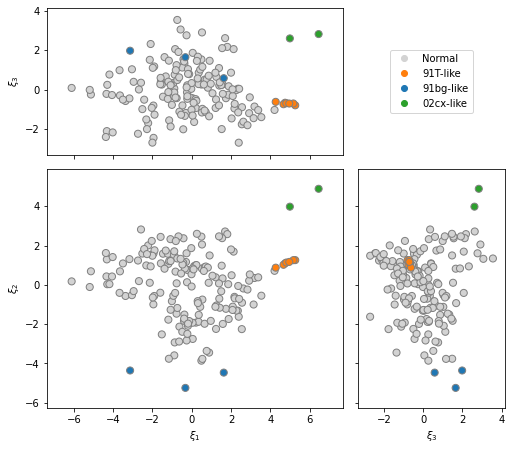

In [17]:
peculiar_colors = {
    'Normal': 'lightgray',
    '91T-like': 'C1',
    '91bg-like': 'C0',
    '02cx-like': 'C2',
}

# Make sure that the peculiar SNe show up on top
order = np.argsort(a.indicators['peculiar_type'])[::-1]
mask = order[a.uncertainty_mask[order]] 

a.scatter_combined(a.indicators['peculiar_type'], mask, discrete_color_map=peculiar_colors)
a.savefig('peculiar_locations.pdf')

In [18]:
# Count how many of each type, and write it out to a latex table
with a.latex_open('peculiar_counts.tex') as f:
    utils.latex_command(f, 'numpeculiarbg', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '91bg-like')))
    utils.latex_command(f, 'numpeculiart', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '91T-like')))
    utils.latex_command(f, 'numpeculiarcx', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '02cx-like')))

\newcommand{\numpeculiarbg}{3}
\newcommand{\numpeculiart}{7}
\newcommand{\numpeculiarcx}{2}


## Sequences of SNe Ia

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import percentileofscore
from matplotlib import colors

In [6]:
dist_matrix = squareform(pdist(a.fractional_differences))
ref_dists = pdist(a.fractional_differences[a.uncertainty_mask])

def find_nearest(coords, mask=a.uncertainty_mask):
    dists = np.sum((a.embedding - np.asarray(coords))**2, axis=1)
    dists[~mask] = np.nan
    loc = np.nanargmin(dists)
    # print(loc, a.targets[loc], a.embedding[loc], a.indicators['peculiar_type'][loc])
    return loc
    
def find_sequence(start_coords, end_coords, mask=a.uncertainty_mask, num_steps=10):
    start_coords = np.asarray(start_coords)
    end_coords = np.asarray(end_coords)
    
    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])

    # cmap = a.settings['colormap']
    # cmap = plt.cm.plasma
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    # sm._A = []
    
    # Make a truncated colormap
    cmap = plt.cm.viridis
    # cmap = plt.cm.plasma
    cmap = colors.LinearSegmentedColormap.from_list('cut_cmap', cmap(np.linspace(0., 0.8, 100)))
    # cmap = a.settings['colormap']
    # cmap = plt.cm.plasma
    # cmap = plt.cm.jet

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0., vmax=1.))
    sm._A = []
    
    locs = []
    
    for frac in np.linspace(0, 1, num_steps):
        coords = start_coords + frac * (end_coords - start_coords)
        loc = find_nearest(coords, mask)
        
        if len(locs) == 0 or loc != locs[-1]:
            if frac == 0 or frac == 1:
                ls = '--'
            else:
                ls = '-'
            name = a.targets[loc].name
            iau_name = a.iau_name_map.get(name, name)
            a.plot_flux(ax, a.scale_flux[loc], c=sm.to_rgba(frac), label=iau_name, zorder=np.abs(frac - 0.5), ls=ls)
            print_str = f'{loc:3d} {name:20s} {a.embedding[loc, 0]:5.2f} {a.embedding[loc, 1]:5.2f} {a.embedding[loc, 2]:5.2f}   {a.indicators["peculiar_type"][loc]:20s}'
            if len(locs) > 0:
                print_str += f' {percentileofscore(ref_dists, dist_matrix[loc, locs[-1]]):.2f}'
            print(print_str)
            locs.append(loc)
        
    ax.legend(ncol=3)
    ax.set_ylim(0, 0.75)
    
    return locs

### Sequence from 91bg to 91T

 40 PTF11kjn             -0.32 -5.24  1.66   91bg-like           
193 SNNGC6343             0.54 -3.77  1.16   Normal               29.45
200 SNhunt281             0.76 -3.36  0.52   Normal               5.04
171 SNF20080810-001       1.88 -1.74  0.17   Normal               15.43
181 SNF20080918-002       2.08 -1.28  0.02   Normal               1.94
155 SNF20080516-022       2.41 -0.72  0.04   Normal               8.17
173 SNF20080822-005       2.96  0.53 -0.39   Normal               17.21
156 SNF20080522-000       4.27  0.88 -0.62   91T-like             5.86
\newcommand{\sequencebgname}{PTF11kjn}
\newcommand{\sequencebgcoord}{($-0.32, -5.24, 1.66$)}
\newcommand{\sequencebgtwin}{SN2013bs}
\newcommand{\sequencebgtwinpercentile}{29}
\newcommand{\sequencebgtcount}{8}
\newcommand{\sequencetname}{SNF20080522-000}
\newcommand{\sequencetcoord}{($4.27, 0.88, -0.62$)}
\newcommand{\sequencettwin}{SNF20080522-000}
\newcommand{\sequencettwinpercentile}{5}


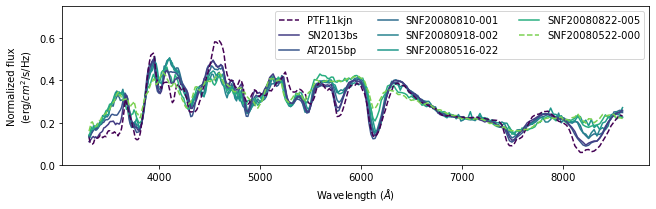

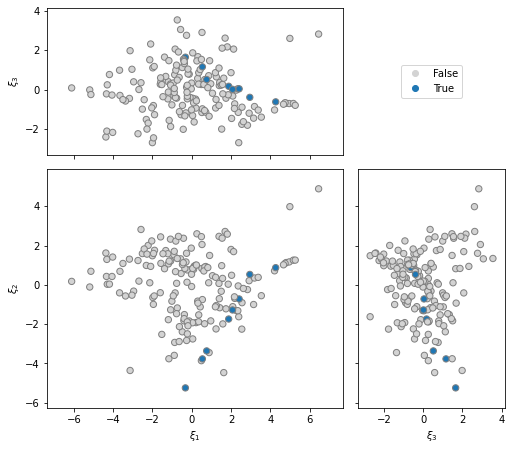

In [7]:
locs_91bg_91t = find_sequence([-0.3, -5.3, 2], [4., 2., -0.5], a.uncertainty_mask, 10)

a.savefig('sequence_91bg_91t.pdf')

label_colors = {
    False: 'lightgray',
    True: 'C0',
}
used_mask = np.array([i in locs_91bg_91t for i in range(len(a.targets))])
a.scatter_combined(used_mask, a.uncertainty_mask, discrete_color_map=label_colors, s=40)

def iau_name(name):
    return a.iau_name_map.get(name, name)

with a.latex_open('sequence_peculiars.tex') as f:
    utils.latex_command(f, 'sequencebgname', '%s', iau_name(a.targets[locs_91bg_91t[0]].name))
    utils.latex_command(f, 'sequencebgcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_91bg_91t[0]]))
    utils.latex_command(f, 'sequencebgtwin', '%s', iau_name(a.targets[locs_91bg_91t[1]].name))
    utils.latex_command(f, 'sequencebgtwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_91bg_91t[0], locs_91bg_91t[1]]))
    utils.latex_command(f, 'sequencebgtcount', '%d', len(locs_91bg_91t))
    utils.latex_command(f, 'sequencetname', '%s', iau_name(a.targets[locs_91bg_91t[-1]].name))
    utils.latex_command(f, 'sequencetcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_91bg_91t[-1]]))
    utils.latex_command(f, 'sequencettwin', '%s', iau_name(a.targets[locs_91bg_91t[-1]].name))
    utils.latex_command(f, 'sequencettwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_91bg_91t[-1], locs_91bg_91t[-2]]))

### Sequence from normal to 02cx

 62 SN2005cc              4.99  3.98  2.61   02cx-like           
101 SNF20060512-001       1.81  2.58  2.18   Normal               64.82
 20 PTF10hmv              0.91  1.50  1.47   Normal               8.36
179 SNF20080914-001       0.05  0.84  1.88   Normal               5.34
 29 PTF10ufj             -1.38  0.82  1.66   Normal               5.17
 36 PTF11bnx             -2.13  0.11  1.52   Normal               5.65
 55 PTF13anh             -3.04 -0.52  1.04   Normal               7.92
 38 PTF11cao             -3.67 -0.41  0.99   Normal               1.83
\newcommand{\sequencecxname}{SN2005cc}
\newcommand{\sequencecxcoord}{($4.99, 3.98, 2.61$)}
\newcommand{\sequencecxtwin}{SNF20060512-001}
\newcommand{\sequencecxtwinpercentile}{64}
\newcommand{\sequencecxend}{PTF11cao}


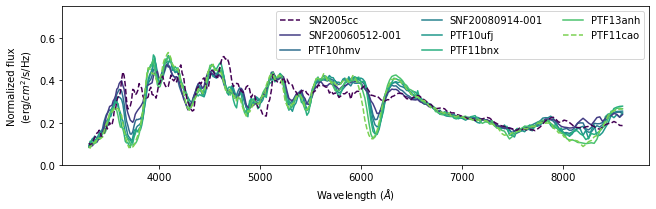

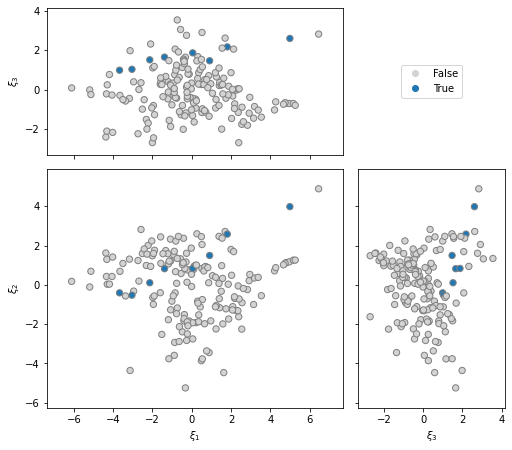

In [8]:
locs_02cx = find_sequence([5., 4., 2.], [-4., -1., 1.], a.uncertainty_mask, 10)

a.savefig('sequence_02cx.pdf')

label_colors = {
    False: 'lightgray',
    True: 'C0',
}
used_mask = np.array([i in locs_02cx for i in range(len(a.targets))])
a.scatter_combined(used_mask, a.uncertainty_mask, discrete_color_map=label_colors, s=40)

with a.latex_open('sequence_peculiars_cx.tex') as f:
    utils.latex_command(f, 'sequencecxname', '%s', a.targets[locs_02cx[0]].name)
    utils.latex_command(f, 'sequencecxcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_02cx[0]]))
    utils.latex_command(f, 'sequencecxtwin', '%s', a.targets[locs_02cx[1]].name)
    utils.latex_command(f, 'sequencecxtwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_02cx[0], locs_02cx[1]]))
    utils.latex_command(f, 'sequencecxend', '%s', a.targets[locs_02cx[-1]].name)

### Combined plot

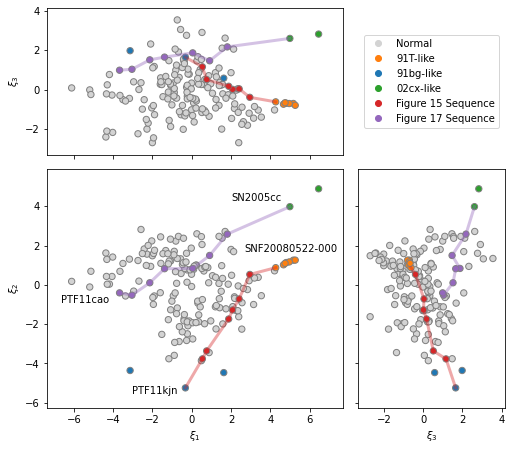

In [10]:
label_colors = {
    'Normal': 'lightgray',
    '91T-like': 'C1',
    '91bg-like': 'C0',
    '02cx-like': 'C2',

    'Figure 15 Sequence': 'C3',
    'Figure 17 Sequence': 'C4',
}
labels = np.array(a.indicators['peculiar_type'], dtype='U30')
for loc in locs_02cx:
    if labels[loc] == 'Normal':
        labels[loc] = 'Figure 17 Sequence'
for loc in locs_91bg_91t:
    if labels[loc] == 'Normal':
        labels[loc] = 'Figure 15 Sequence'
        
# Make sure that the peculiar SNe show up on top
order = np.argsort(labels != 'Normal')
mask = order[a.uncertainty_mask[order]] 

ax12, ax13, ax32 = a.scatter_combined(labels, mask, discrete_color_map=label_colors, s=40)

def plot_sequence(locs, **kwargs):
    coord = a.embedding[locs]
    ax12.plot(coord[:, 0], coord[:, 1], **kwargs)
    ax13.plot(coord[:, 0], coord[:, 2], **kwargs)
    ax32.plot(coord[:, 2], coord[:, 1], **kwargs)
    
plot_sequence(locs_91bg_91t, c='C3', alpha=0.4, lw=3)
plot_sequence(locs_02cx, c='C4', alpha=0.4, lw=3)

def show_label(loc, offset_x, offset_y):
    name = a.targets[loc].name
    coord = a.embedding[loc]
    ax12.text(coord[0] + offset_x, coord[1] + offset_y, name)

show_label(locs_02cx[0], -3, 0.3)
show_label(locs_02cx[-1], -3, -0.5)
show_label(locs_91bg_91t[0], -2.7, -0.3)
show_label(locs_91bg_91t[-1], -1.6, 0.8)

a.savefig('sequence_locations.pdf')

## Color comparison

(<AxesSubplot:xlabel='$\\xi_1$', ylabel='$\\xi_2$'>,
 <AxesSubplot:ylabel='$\\xi_3$'>,
 <AxesSubplot:xlabel='$\\xi_3$'>)

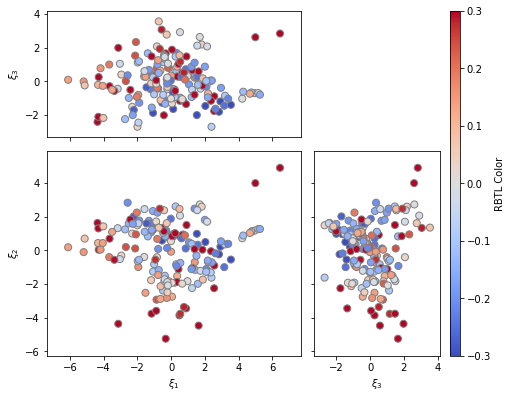

In [24]:
a.scatter_combined(a.rbtl_colors, a.uncertainty_mask, vmin=-0.3, vmax=0.3, label='RBTL Color')

## SALT2 x1 comparison

(<AxesSubplot:xlabel='$\\xi_1$', ylabel='$\\xi_2$'>,
 <AxesSubplot:ylabel='$\\xi_3$'>,
 <AxesSubplot:xlabel='$\\xi_3$'>)

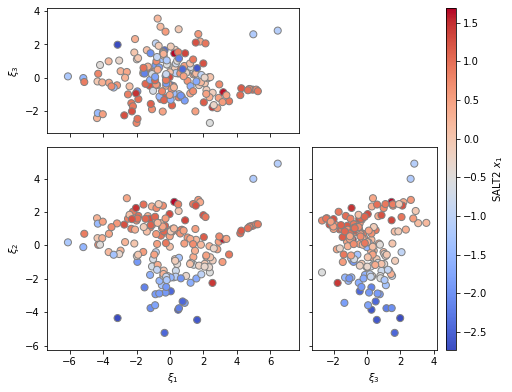

In [25]:
a.scatter_combined(a.salt_x1, a.uncertainty_mask, label='SALT2 $x_1$')

# Variants of generating the manifold

In [55]:
# Set the seed so that we get the same results for random functions each time.
np.random.seed(0)

from manifold_gp import ManifoldGaussianProcess
    
# Apply some alternative binning.
def do_binning(spec, count=1, start_wave=None, end_wave=None):
    if start_wave is None:
        start = 0
    else:
        # Convert the wave to a bin number
        start = np.argmin(np.abs(a.wave - start_wave))

    if end_wave is None:
        end = len(a.wave)
    else:
        # Convert the wave to a bin number
        end = np.argmin(np.abs(a.wave - end_wave))

    # Cut a bit off the end if our bins don't quite match up.
    end = start + count * ((end - start) // count)

    out_spec = 0.
    for i in range(count):
        out_spec += spec[..., start+i:end:count]

    return out_spec

def get_fractional_diffs(**kwargs):
    bin_flux = do_binning(a.scale_flux, **kwargs)
    bin_mean_flux = do_binning(a.mean_flux, **kwargs)

    fractional_diffs = bin_flux / bin_mean_flux - 1

    return fractional_diffs

variants = {
    '# Neighbors = 5': {'num_neighbors': 5},
    '# Neighbors = 8': {'num_neighbors': 8},
    '# Neighbors = 20': {'num_neighbors': 20},
    '# Neighbors = 50': {'num_neighbors': 50},
    'No uncertainty cuts': {'mask': np.ones(len(a.targets), dtype=bool)},
    'Discard 20% of SNe': {'mask': a.uncertainty_mask & (np.random.rand(len(a.targets)) > 0.2)},
    'Discard 50% of SNe': {'mask': a.uncertainty_mask & (np.random.rand(len(a.targets)) > 0.5)},
    'Resampled uncertainties': {'data': a.fractional_differences + np.random.normal(0, a.fractional_difference_uncertainties)},
    'Added noise, S/N = 20': {'data': a.fractional_differences + np.random.normal(0, 0.05, a.fractional_differences.shape)},
    'Added noise, S/N = 10': {'data': a.fractional_differences + np.random.normal(0, 0.1, a.fractional_differences.shape)},
    'Added noise, S/N = 5': {'data': a.fractional_differences + np.random.normal(0, 0.2, a.fractional_differences.shape)},
    'Added noise, S/N = 2': {'data': a.fractional_differences + np.random.normal(0, 0.5, a.fractional_differences.shape)},
    'Binning 2000 km/s': {'data': get_fractional_diffs(count=2)},
    'Binning 5000 km/s': {'data': get_fractional_diffs(count=5)},
    'Binning 10000 km/s': {'data': get_fractional_diffs(count=10)},
    'Wavelength > 4000 $\AA$': {'data': get_fractional_diffs(start_wave=4000.)},
    'Wavelength > 5000 $\AA$': {'data': get_fractional_diffs(start_wave=5000.)},
    'Wavelength < 8000 $\AA$': {'data': get_fractional_diffs(end_wave=8000.)},
    'Wavelength < 7000 $\AA$': {'data': get_fractional_diffs(end_wave=7000.)},
}

all_exp_vars = []

for variant, variant_params in tqdm(variants.items()):
    embedding = a.generate_embedding(**variant_params)
    
    mask = a.uncertainty_mask
    if 'mask' in variant_params:
        mask = mask & variant_params['mask']

    ref_embedding = a.embedding
    use_embedding = embedding
    
    exp_vars = []
    for ref_vals in ref_embedding.T:
        gp = ManifoldGaussianProcess(a, use_embedding, ref_vals, np.zeros_like(ref_vals), mask=mask)
        gp.fit(verbosity=-1, cov=False)

        exp_vars.append(1 - (gp.parameters[0] / np.std(ref_vals))**2)

    all_exp_vars.append(exp_vars)

all_exp_vars = np.array(all_exp_vars)

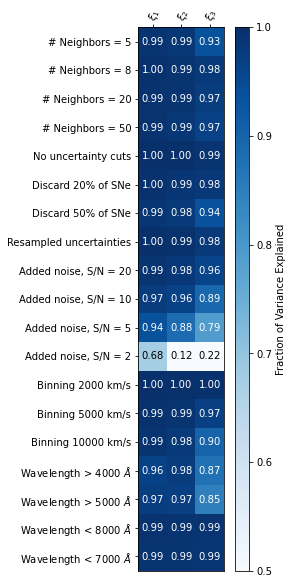

In [57]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=(4., 10.), constrained_layout=False)

cmap = plt.cm.Blues
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.5, vmax=1.))
sm._A = []

def do_plot(ax, ax_data, sm, xlabels, ylabels=None, threshold=0.7):
    ax_data = np.atleast_2d(ax_data)
    im = ax.imshow(sm.to_rgba(np.abs(ax_data)), interpolation='nearest', vmin=-1, vmax=1)
    ax.set(
        xticks=np.arange(ax_data.shape[1]),
        yticks=np.arange(ax_data.shape[0]),
        xticklabels=xlabels,
    )

    if ylabels is not None:
        ax.set_yticklabels(ylabels)
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False)

    # Ticks on top
    ax.get_xaxis().set_ticks_position('top')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=70, ha="left", va='center',
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    for i in range(ax_data.shape[0]):
        for j in range(ax_data.shape[1]):
            label = f'{ax_data[i, j]:.2f}'
            ax.text(j, i, label, ha="center", va="center",
                    color="white" if np.sign(threshold) * np.abs(ax_data[i, j]) > threshold else "black")

do_plot(ax, all_exp_vars, sm, ['$\\xi_1$', '$\\xi_2$', '$\\xi_3$'], variants.keys())

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', aspect=40, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1], label='Fraction of Variance Explained')
# cbar = fig.colorbar(sm, ax=ax, orientation='vertical', aspect=30, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1], label='Pearson Correlation')


a.savefig('cross_validation_manifold.pdf', bbox_inches='tight', pad_inches=0)